In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, classification_report
sns.set(style="whitegrid", color_codes=True)
#from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [5]:
data=pd.read_csv('C:\\Users\\Vera\\Desktop\\Baze\\bank-full.csv', header=0, sep=';')
data.info()
data.head()
columns_name = list(data.columns)
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
(45211, 17)


In [6]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
data_cat = data.select_dtypes(include='object').copy()
data_num =  data.select_dtypes(include='int64').copy()

In [8]:
categories = [data[x].unique() for x in columns_name if data[x].dtypes == 'object']
most_freq_cat = [data[x].mode() for x in columns_name if data[x].dtypes == 'object']
print (most_freq_cat)

[0    blue-collar
dtype: object, 0    married
dtype: object, 0    secondary
dtype: object, 0    no
dtype: object, 0    yes
dtype: object, 0    no
dtype: object, 0    cellular
dtype: object, 0    may
dtype: object, 0    unknown
dtype: object, 0    no
dtype: object]


In [9]:
data_cat_new = data_cat.replace('unknown',np.nan, inplace=True)
data_cat_new = data_cat.fillna(data_cat.mode().iloc[0])
data_cat_new.isnull().values.any()
data_cat_new.isnull().sum()

job          0
marital      0
education    0
default      0
housing      0
loan         0
contact      0
month        0
poutcome     0
y            0
dtype: int64

In [11]:
data_cat_new.apply(pd.value_counts)
freq_of_cat = [data_cat_new[x].value_counts() for x in data_cat_new.columns]
print (freq_of_cat)

[blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: job, dtype: int64, married     27214
single      12790
divorced     5207
Name: marital, dtype: int64, secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64, no     44396
yes      815
Name: default, dtype: int64, yes    25130
no     20081
Name: housing, dtype: int64, no     37967
yes     7244
Name: loan, dtype: int64, cellular     42305
telephone     2906
Name: contact, dtype: int64, may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64, failure    41860
other       1840
success     1511
Name: poutcome, dtype: int64, no     39922
yes     5289
Name: y, dtype: int64]


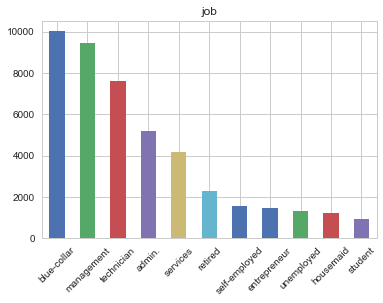

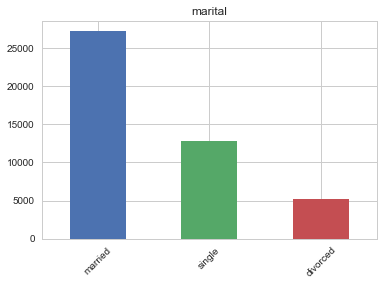

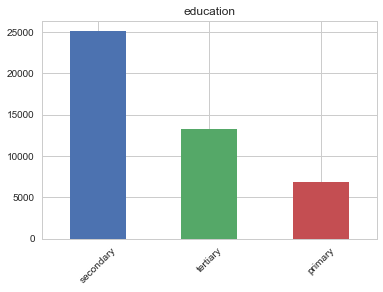

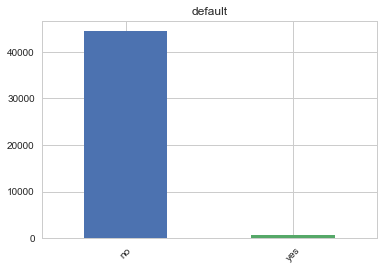

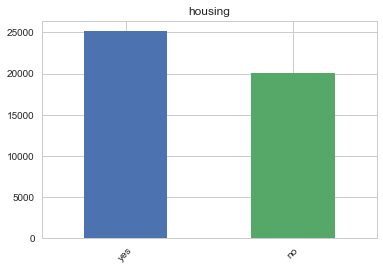

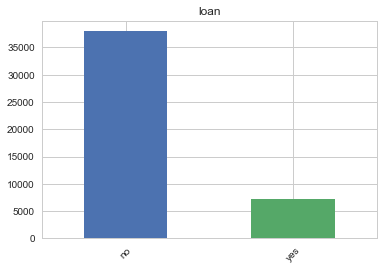

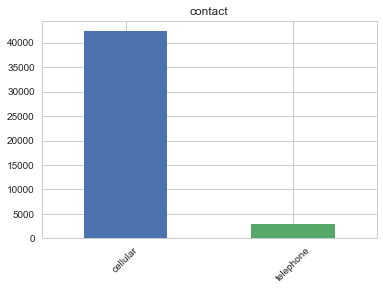

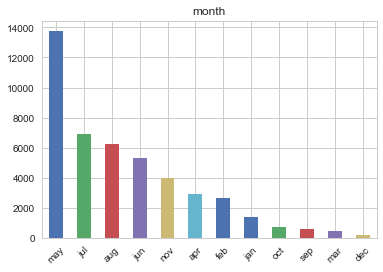

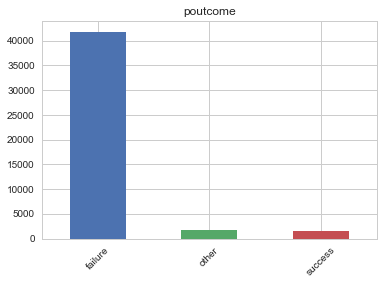

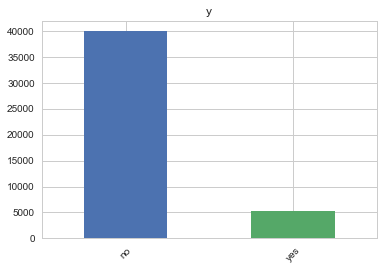

In [12]:
for i in range(len(freq_of_cat)):
    plt.figure()
    freq_of_cat[i].plot(kind='bar')
    plt.title(freq_of_cat[i].name)
    plt.xticks(rotation=45)
plt.show()

In [13]:
data_cat_new['job_new']=np.where(data_cat_new['job'] =='student', 'unemployed', data_cat_new['job'])
data_cat_new['job_new']=np.where(data_cat_new['job_new'] =='housemaid', 'unemployed', data_cat_new['job_new'])
data_cat_new['job_new']=np.where(data_cat_new['job_new'] =='entrepreneur', 'self-employed', data_cat_new['job_new'])
data_cat_new['job_new'].value_counts()

blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
unemployed        3481
self-employed     3066
retired           2264
Name: job_new, dtype: int64

In [11]:
data_cat_new['education'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

In [12]:
data_cat_new['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [14]:
education_order = ['primary', 'secondary', 'tertiary']
month_order = ['jan', 'feb','mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)
    
ordered_labels(data_cat_new, 'education', education_order)
ordered_labels(data_cat_new, 'month', month_order)

In [15]:
cat_vars = data_cat_new.columns
for var in cat_vars:
    cat_list='var'+'.'+var
    cat_list = pd.get_dummies(data_cat_new[var], prefix=var,drop_first=True)
    data1=data_cat_new.join(cat_list)
    data_cat_new=data1

data_cat_new_vars=data_cat_new.columns.values.tolist()
to_keep=[i for i in data_cat_new_vars if i not in cat_vars]

data_cat_new1 = data_cat_new[to_keep]

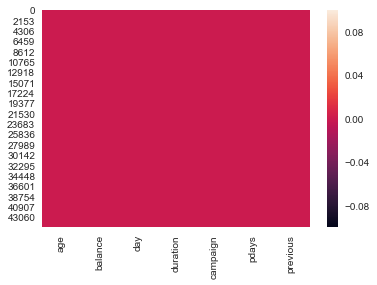

In [16]:
data_num.isnull().values.any()
data_num.isnull().sum()
sns.heatmap(data_num.isnull())

In [17]:
data_num['pdays_new']=np.where(data_num['pdays']==-1, 'not contacted', 'contacted' )
data_num=pd.concat([data_num, pd.get_dummies(data_num['pdays_new'],drop_first=True)],axis=1, sort=False)
data_num = data_num.drop(['pdays', 'pdays_new'],1)

In [17]:
data_num.mean()

age                40.936210
balance          1362.272058
day                15.806419
duration          258.163080
campaign            2.763841
previous            0.580323
not contacted       0.817367
dtype: float64

In [18]:
numerical = data_num.select_dtypes(include='int64').copy()
numerical_names = data_num.select_dtypes(include='int64').columns
numerical_cat = data_num.select_dtypes(include='uint8').copy()

In [19]:
scaler = MinMaxScaler()
numerical = scaler.fit_transform(numerical)
numerical = pd.DataFrame(numerical )
numerical.columns = numerical_names
numerical.mean()
data_num_new = pd.concat([numerical,data_num['not contacted']],axis=1, sort=False)

In [20]:
data_new = pd.concat([data_cat_new1, data_num_new], axis=1, sort=False)

In [21]:
data_new.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,job_new_services,job_new_technician,job_new_unemployed,age,balance,day,duration,campaign,previous,not contacted
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0.519481,0.092259,0.133333,0.053070,0.0,0.0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0.337662,0.073067,0.133333,0.030704,0.0,0.0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.194805,0.072822,0.133333,0.015453,0.0,0.0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.376623,0.086476,0.133333,0.018707,0.0,0.0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.194805,0.072812,0.133333,0.040260,0.0,0.0,1


In [22]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 46 columns):
job_blue-collar          45211 non-null uint8
job_entrepreneur         45211 non-null uint8
job_housemaid            45211 non-null uint8
job_management           45211 non-null uint8
job_retired              45211 non-null uint8
job_self-employed        45211 non-null uint8
job_services             45211 non-null uint8
job_student              45211 non-null uint8
job_technician           45211 non-null uint8
job_unemployed           45211 non-null uint8
marital_married          45211 non-null uint8
marital_single           45211 non-null uint8
education_1              45211 non-null uint8
education_2              45211 non-null uint8
default_yes              45211 non-null uint8
housing_yes              45211 non-null uint8
loan_yes                 45211 non-null uint8
contact_telephone        45211 non-null uint8
month_1                  45211 non-null uint8
month_2          

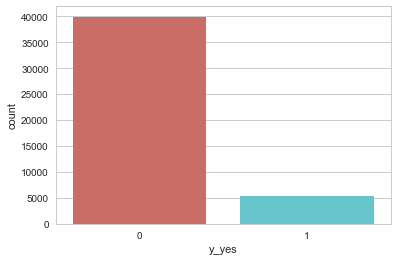

In [21]:
data_new['y_yes'].value_counts()
sns.countplot(x='y_yes', data=data_new, palette = 'hls')
plt.show()

In [22]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=101):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

train, validate, test = train_validate_test_split(data_new)
X_train = train.drop('y_yes',1)
y_train = train['y_yes']
X_validation = validate.drop('y_yes',1)
y_validation = validate['y_yes']
X_test = test.drop('y_yes',1)
y_test = test['y_yes']

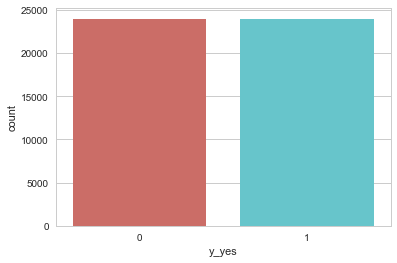

In [23]:
balanced = SMOTE(random_state=0)
balanced_data_X,balanced_data_y=balanced.fit_sample(X_train, y_train)
balanced_data_X = pd.DataFrame(data=balanced_data_X,columns=X_train.columns )
balanced_data_y= pd.DataFrame(data=balanced_data_y,columns=['y_yes'])
sns.countplot(x='y_yes', data=balanced_data_y, palette = 'hls')
plt.show()

In [24]:
logreg = LogisticRegression()
logreg.fit(balanced_data_X, balanced_data_y.values.ravel())
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.84


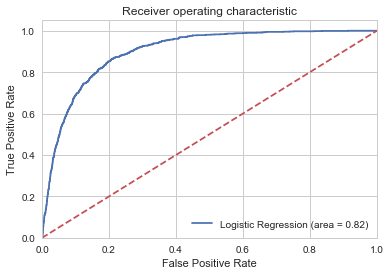

In [25]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

[[6803 1166]
 [ 239  835]]
             precision    recall  f1-score   support

          0       0.97      0.85      0.91      7969
          1       0.42      0.78      0.54      1074

avg / total       0.90      0.84      0.86      9043



In [29]:
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.899537


In [27]:
fpr, tpr, thresholds = roc_curve(y_validation, logreg.predict_proba(X_validation)[:,1])
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
975,0.178433,0.821931,0.821567,0.000363,0.434995


In [29]:
THRESHOLD = 0.43
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
print(classification_report(y_test, preds))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, preds)))

             precision    recall  f1-score   support

          0       0.97      0.82      0.89      7969
          1       0.38      0.82      0.52      1074

avg / total       0.90      0.82      0.84      9043

Accuracy of logistic regression classifier on test set: 0.96


In [30]:
grid={"C":np.array([0.001,0.01,0.1,1,10]), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_validation,y_validation)
# View best hyperparameters
print('Best Penalty:', logreg_cv.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_cv.best_estimator_.get_params()['C'])


Best Penalty: l1
Best C: 1.0


In [31]:
logreg = LogisticRegression(penalty='l1', C=1)
logreg.fit(balanced_data_X, balanced_data_y.values.ravel())
THRESHOLD = 0.43
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
print(classification_report(y_test, preds))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, preds)))


             precision    recall  f1-score   support

          0       0.97      0.82      0.89      7969
          1       0.38      0.83      0.52      1074

avg / total       0.90      0.82      0.85      9043

Accuracy of logistic regression classifier on test set: 0.97
